In [ ]:
###########################
#Noise QFT
#search for the return probabilities, calculate stability of each case 
#with more than one error
###########################

In [135]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from sympy import factorint
from fractions import Fraction
from numpy import linalg
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random
import math

import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix

from qiskit.quantum_info import Statevector

In [136]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(16, 6))

In [137]:
def qft_rotations(circuit, n, n_max,  case, position):
    tmp = n_max - case
    
    if n == 0:
        return circuit
    n -= 1    

    if n  == tmp:
        errori(circuit, position, n)  
    
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case, position)

In [138]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [139]:
def errori(circuit, position, n):
    epsilon = 0.5                                #probability p of x error, 1-p prob. of z error                         
    extracted = random.uniform(0, 1)
    
    if (extracted < epsilon):    
        circuit.x(position)   
        #flag = 0
        circuit.barrier(range(n))
    else:
        circuit.z(position)
        #flag = 1
        circuit.barrier(range(n))
    return circuit

In [140]:
def qft(circuit, n, n_max, case, position):
    if case == 1:
        errori(circuit, position, n) 

    qft_rotations(circuit, n, n_max, case, position)

    if case == n + 1:
        errori(circuit, position, n)
    
    swap_registers(circuit, n)    

    if case == n + 2:
        errori(circuit, position , n)
        
    if case == 0:
        pass
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [141]:
def split_circuit_by_barrier(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('barrier'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

In [142]:
def split_circuit_by_error(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('z'):
            break
        elif line.startswith('x'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))


In [150]:
n = 4

#Each line contains the results of the aplitude for each state of the complete basis
amplitudes = np.empty((n + 3, n))
x = []
plot = []
#change case (0, n + 2) and position (0,n - 1), case = 0 means no errors

for reps in range(25):
    for case in range(0, n + 3):
        for position in range(n):

            #print(case, position)
            control = QuantumRegister(n, 'r1')
            circuit = QuantumCircuit(control)

            qft(circuit, n, n, case, position) 

            for subcircuit in (split_circuit_by_barrier(circuit)):
                circuit_right = subcircuit

            for subcircuit in (split_circuit_by_error(circuit)):
                circuit_left = subcircuit

            circuit_right = circuit_right.inverse()


            merge = circuit_left.compose(circuit_right)
            #merge.draw('mpl',  fold = -1, scale = 0.5)

            backend = Aer.get_backend('unitary_simulator')
            job = execute(merge, backend, shots = 8192)
            result = job.result()
            UeU = result.get_unitary(merge,3)
            #print(UeU)

            #Ciclo sugli stati iniziali
            summa_states = 0
            for iii in range(2**n):   

                label = bin(iii).lstrip('-0b').zfill(n)
                #print(label)
                #create list of label for plot
                if case == 0:
                    x.append(label)

                state = Statevector.from_label(label)
                summa_states = summa_states + (state.evolve(UeU)[label]**2).real
                iii += 1
                state = 0
                amplitudes[case][position] = summa_states
            merge = 0
            result = 0
            circuit = 0
            UeU = 0

    #print(amplitudes.sum(axis = 1)/(n*(2**n)))
    plot.append(amplitudes.sum(axis = 1)/(n*(2**n)))
    reps += 1

In [151]:
media = np.empty(n + 3)

for i in range(0, n + 3):
    for ii in range(reps):
        media[i] = media[i] + plot[ii][i]
    media[i] = media[i]/reps

In [152]:
media

array([3.56      , 0.55      , 1.39506358, 0.99000539, 1.35005836,
       0.91005444, 1.30500042])

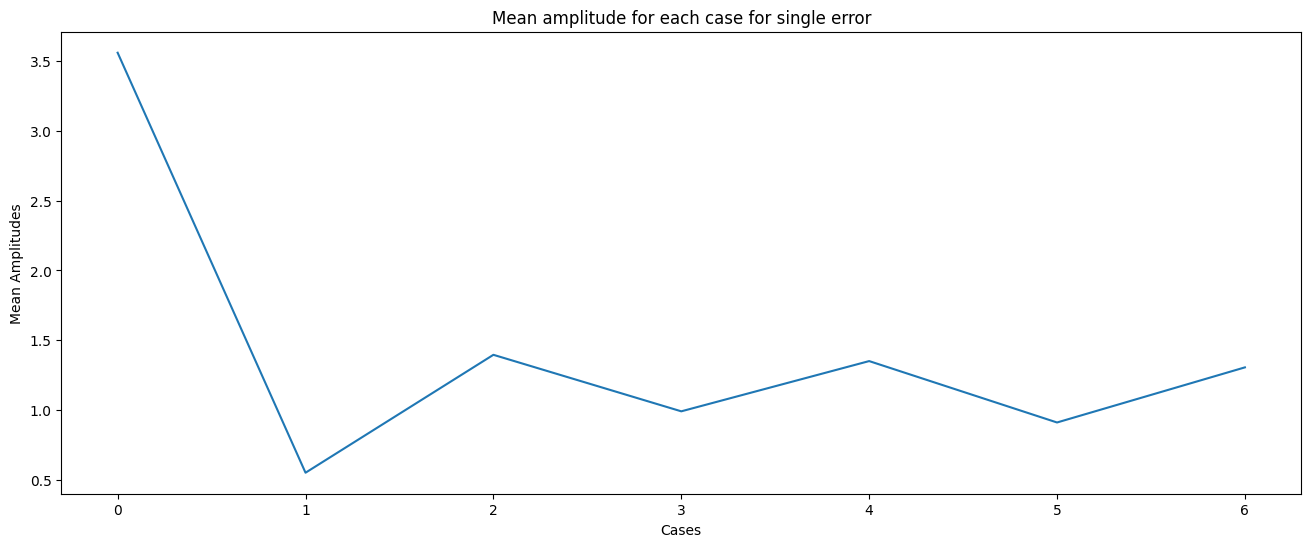

In [154]:
plt.xlabel('Cases')
plt.ylabel('Mean Amplitudes')
plt.title('Mean amplitude for each case for single error')
plt.plot(media)
plt.savefig('cases_single_error.pdf', format = 'pdf') 